# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from pylab import rcParams
from matplotlib import dates
from tqdm import tqdm

# Import the models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Import the metrics module 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [2]:
# Setting the plotting theme
sns.set()
sns.set_theme(style="darkgrid")

# and setting the size of all plots
plt.rcParams['figure.figsize'] = 10, 4

# and setting the colors
color = ["#4b85a8", "#d98100", "#aba597"]


In [3]:
# Read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)


Functions for visualization plots.

In [4]:
# Function for pie plot 
def plot_pie(data,labels, title):
    """Get the data and pie plot with labels

    Args:
      data (pandas DataFrame): The DataFrame with a specific numeric column to plot.
      labels (list): A sequence of strings providing the labels for each wedge
      title(str): The title for the plot.


    Returns:
      pie plot 
    """
    ax = plt.figure(figsize = (4.5,4.5))

    ax = plt.pie(data, labels = labels, 
                 autopct='%1.0f%%',startangle = 90, 
                 textprops={'fontsize': 13}  )
    
    plt.title(title, fontsize=18)
    

In [5]:
def countplot_h(data, title):
    """Get dataframe specific column and count the amount of each type, 
       and plot horizontal bars with labels.

    Args:
      data (pandas DataFrame): The DataFrame with specific columns to plot.
      title (str): The title for the plot.


    Returns:
      plot horizontal bars
    """
            
     # Plotting data
    ax = sns.countplot(y = data, order = data.value_counts().index);
    
    # Set labels and legend
    ax.set_title(title, fontsize=18)
    plt.rc('legend', fontsize=13)
    
    # Patches is everything inside of the chart
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{width:.0f}'

        # ax.text(x, y, text)
        label_x = x + width/2
        label_y = y + height/2

        # plot only when height is greater than specified value
        if height > 0:
            ax.text(
                label_x,
                label_y,
                label_text,
                ha='center',
                va='center',
                fontsize=14
                )
    
    ax.set_title(title, size = 14)
    plt.show()


In [6]:
def plotting_histplot(data, title):
    """Get the data and plot histplot with median and mean

    Args:
      data (pandas DataFrame): The DataFrame with specific columns to plot.


    Returns:
      histplot
    """
    # Initalize a figure and axes
    fig, axes = plt.subplots(ncols=1, nrows=1)

    # Plot the data
    sns.histplot(data)
        
    axes.axvline(
              x=data.median(),
              color="#d98100",
              label="Median: " + str(int(data.median())),
              linestyle='--', linewidth=2
              )

    axes.axvline(
              x=data.mean(), color="#d98100",
              label="Mean: " + str(int(data.mean())),
              linestyle='-',
              linewidth=2
              )
    
    axes.set_title(title, size = 14)

    axes.legend()

    plt.show()


In [7]:
def countplot_v(data, title):
    """Get dataframe specific column and count the amount of each type, 
       and plot bars with labels.

    Args:
      data (pandas DataFrame): The DataFrame with specific columns to plot.
      title (str): The title for the plot.


    Returns:
      plot bars
    """
       
     # Plotting data
    ax = sns.countplot(x = data, order = data.value_counts().index);
    
    # Set labels and legend
    ax.set_title(title, fontsize=18)
    plt.rc('legend', fontsize=13)
    
    # Patches is everything inside of the chart
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{height:.0f}'

        # ax.text(x, y, text)
        label_x = x + width/2
        label_y = y + height/2

        # plot only when height is greater than specified value
        if height > 0:
            ax.text(
                label_x,
                label_y,
                label_text,
                ha='center',
                va='center',
                fontsize=14
                )
    
    ax.set_title(title, size = 14)
    plt.show()


In [8]:
def plot_bar(data, xlabel, ylabel, title):
    """Get the data and plot vertical bars

    Args:
      data (pandas DataFrame): The DataFrame with specific columns to plot.
      xlabel (str): The label for x axis.
      ylabel (str): The label for y axis.
      title (str): The title for the plot.
      period (strftime) : The period of time


    Returns:
      plot bars
    """
    # Plotting data
    ax = data.plot.bar(color=color)

    # Set labels and legend
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=18)

    ax.legend(loc='best')
    plt.rc('legend', fontsize=13)

    # Patches is everything inside of the chart
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{height:.0f}'

        # ax.text(x, y, text)
        label_x = x + width/2
        label_y = y + height/2

        # plot only when height is greater than specified value
        if height > 0:
            ax.text(
                label_x,
                label_y,
                label_text,
                ha='center',
                va='center',
                fontsize=13
                )


In [9]:
def bar_stacked (data, title):
    """Get dataframe and plot vertically stacked bars  with labels
    
    Args:
      data (pandas DataFrame): The DataFrame to plot.
      title (str): The title for the plot.


    Returns:
      plot vertically stacked bars  with labels
    """
    
    # Plot stacked bars
    ax = data.plot(kind='bar', stacked=True)

    # Set labels and legend
    ax.set_title(title, fontsize=15)
    ax.legend(loc='best')
    plt.rc('legend', fontsize=15)

    # Patches is everything inside of the chart
    for rect in ax.patches:

        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{height:.0f}'

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2

        # plot only when height is greater than specified value
        if height > 0:
            ax.text(label_x, label_y,
                    label_text, ha='center',
                    va='center', fontsize=12)


In [10]:
def plot_line(data, xlabel, ylabel, title):
    """Get the data and plot it in lines

    Args:
      data (pandas DataFrame): The data to plot.
      xlabel (str): The label for x axis.
      ylabel (str): The label for y axis.
      title (str): The title for the plot.

    Returns:
      plot
    """

    # Plotting data
    ax = data.plot.line(color=color)

    # Set axis labels and legend
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=18)
    
    ax.set_xlim(1,11)
    ax.set_xticks(range(1,11))

    ax.legend(loc='best')
    plt.rc('legend', fontsize=13)

    # Add labels to line plots
    for i, col in data.iteritems():
        for x, y in zip(data.index, col):
            label = "{:.0f}".format(y)
            plt.annotate(label, (x, y),
                         textcoords="offset points",
                         xytext=(10, 10),
                         ha='center')

    plt.show()


References: https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9

## Exploratory Data Analysis

####  Validate Data
- read data 
- display a summary of the tables
- display the column names of the tables
- rename the columns

#### Cleaning Data

- dropping or filling missing values 
- handling outliers
- changing the types of values

##### 1.1 portfolio DataFrame

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [11]:
# Inspect data
portfolio.head()


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
# Examine the shape
portfolio.shape


(10, 6)

In [13]:
# Print data information
portfolio.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [14]:
# Rename id column to offer_id
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)


In [15]:
print (f"Number of unique offers: {portfolio.offer_id.nunique()}")


Number of unique offers: 10


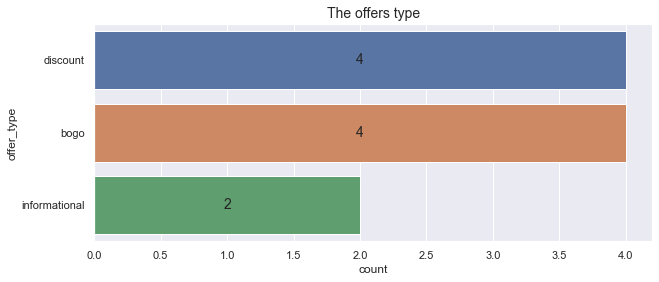

In [16]:
# Plotting offers type
offer_type = portfolio["offer_type"].value_counts().reset_index()
countplot_h(data = portfolio["offer_type"], title = "The offers type")


In [17]:
offer_id_sum = len(portfolio.offer_id.unique())
print (f"The profile DataFrame has {offer_id_sum} unique offer_id")


The profile DataFrame has 10 unique offer_id


"Channels" column made like a list, which means we can't use the standard functions because lists are not hashable. To solve this problem, we use a function which converts 2d to 1d

In [18]:
def to_1D(series):
    """Get dataframe with specific column and reducing its dimensions from 2 to 1

    Args:
      data (series): The DataFrame with specific column.

    Returns:
      1D array
    """
    return pd.Series([x for _list in series for x in _list])


In [19]:
channels = to_1D(portfolio["channels"])

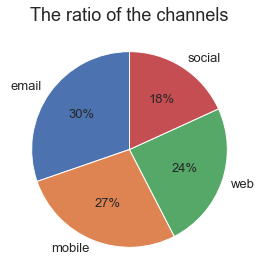

In [20]:
plot_pie(channels.value_counts(),channels.value_counts().index, "The ratio of the channels")


In [21]:
portfolio.head(2)


,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


#### Portfolio Data Cleaning

In [22]:
# Convert time in days into hours
portfolio['duration'] = portfolio['duration']*24


In [23]:
# Converting to the dictionary
offer_id_dict = portfolio.offer_id.to_dict()

# Swap keys and values in the dictionary
offer_id_dict = dict([(value, key+1) for key, value in offer_id_dict.items()])
offer_id_dict


{'ae264e3637204a6fb9bb56bc8210ddfd': 1,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 2,
 '3f207df678b143eea3cee63160fa8bed': 3,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '5a8bc65990b245e5a138643cd4eb9837': 8,
 'f19421c1d4aa40978ebb69ca19b0e20d': 9,
 '2906b810c7d4411798c6938adc9daaa5': 10}

In [24]:
# Replace offer_id value to numeric in range 1 to 10 
portfolio['offer_id'] = portfolio['offer_id'].replace(offer_id_dict)


In [25]:
portfolio


,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,168,bogo,1
1,10,"[web, email, mobile, social]",10,120,bogo,2
2,0,"[web, email, mobile]",0,96,informational,3
3,5,"[web, email, mobile]",5,168,bogo,4
4,5,"[web, email]",20,240,discount,5
5,3,"[web, email, mobile, social]",7,168,discount,6
6,2,"[web, email, mobile, social]",10,240,discount,7
7,0,"[email, mobile, social]",0,72,informational,8
8,5,"[web, email, mobile, social]",5,120,bogo,9
9,2,"[web, email, mobile]",10,168,discount,10


- portfolio df has 10 rows and 6 columns.
- "offer_type" column has 3 unique values: BOGO (4), information (4), discount (2).
- "id" column was renamed to "offer_id". 
- "offer_id" column has 10 unique values.
- replaced values in the "offer_id" column from hashes into numerical.
- "channels" column has four unique values: email, social, mobile, and web. For count, we have to convert from  2D into 1D.


_______

##### 1.2 Profile DataFrame

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [26]:
# Inspect data
profile.head()


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [27]:
# Examine the shape
profile.shape


(17000, 5)

In [28]:
# Print data information
profile.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [29]:
# Rename id column customer_id
profile.rename(columns = {'id': 'customer_id'}, inplace = True)


#### Profile Data Cleaning

In [30]:
# Inspect the missing values
profile.isna().sum()


gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
dtype: int64

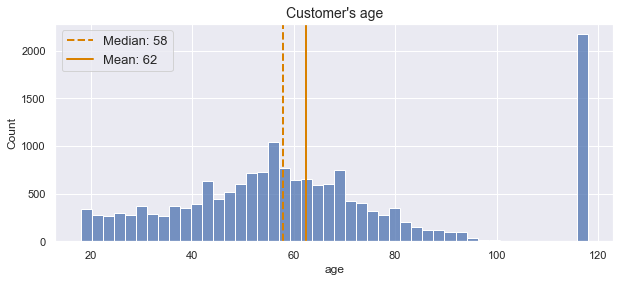

In [30]:
# Histogram of age
plotting_histplot(profile["age"], "Customer's age" )

On the "Customer's age" histogram, we can see that the average age is 62, and the median is 58 years old. But we also see a significant spike in the 118 years old that is a high probability of outliers. When we reduce outliers, the average age might shift to the left. 




In [31]:
# Percentage of the missing values to the entire date
missing_value = int((profile.gender.isnull().sum() / profile.shape[0]) * 100)
print (f"Percentage of the missing values: {missing_value} %")


Percentage of the missing values: 12 %


As we can see, missing values in the "gender" and "income" columns match with the customers whose "age" column is more than 105 years old. How we discuss above, they are outliers.  To avoid overfittings, we drop that rows.

In [32]:
# Drop missing values
profile = profile.dropna()


In [33]:
# Print shape of new  profile dataframe
print(f"The shape of profile DataFrame after dropping rows with missing values: {profile.shape}.")

The shape of profile DataFrame after dropping rows with missing values: (14825, 5).


In [34]:
# Convert string to a date time
profile["became_member_on"] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Create a new column just with years value.
profile["member_since"] =  profile["became_member_on"].dt.year

# Drop "became_member_on" columns from the data frames
profile = profile.drop(["became_member_on"], axis =1)


In [35]:
# Change the data type of 'age' and "income" to int
profile["age"] = profile.age.astype("int64")
profile["income"] = profile.income.astype("int64")


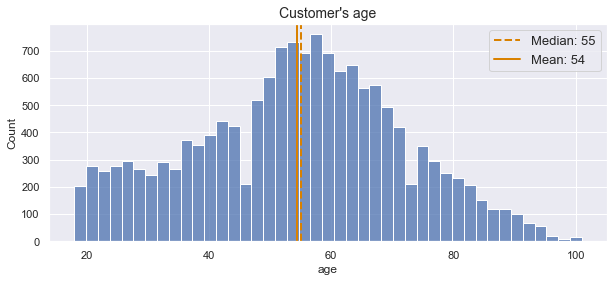

In [36]:
# Histogram of age
plotting_histplot(profile["age"], "Customer's age" )


After dropping the missing value, the histogram shows a slight shift to the left in mean and median. The new average age for customers equals 54 years old, and the median is 55.

In [37]:
# Rearrange columns
profile = profile[["customer_id" , "gender","age", "member_since", "income"]]


In [38]:
profile.head()


,customer_id,gender,age,member_since,income
1,0610b486422d4921ae7d2bf64640c50b,F,55,2017,112000
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,2017,100000
5,e2127556f4f64592b11af22de27a7932,M,68,2018,70000
8,389bc3fa690240e798340f5a15918d5c,M,65,2018,53000
12,2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017,51000


- Profile DataFrame contained _17000_ rows and five columns after dropping the value number of rows equals _14825_.

- The year of 'became_member_on" was extracted in the separate column "member_since," and 'became_member_on" was dropped.

- Rearranged columns order in this way "customer_id" take a 0 index.

- Renamed column "id" to "customer_id"
- Dropped the missing values

1.3 transcript

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [39]:
# Inspect data
transcript.head(2)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [40]:
# Print data information
transcript.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [41]:
# Examine the shape
transcript.shape


(306534, 4)

In [42]:
# Rename person column to customer_id 
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)


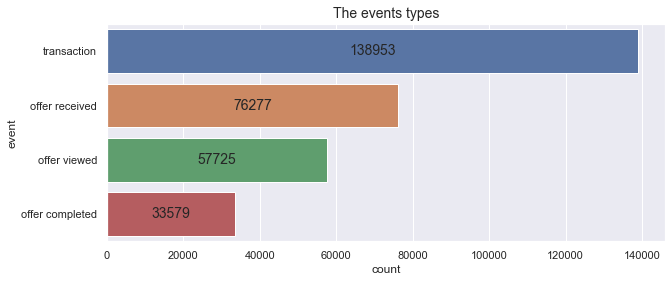

In [43]:
# Showing the ratio of transcripts by event
countplot_h(data = transcript["event"], title = "The events types")


#### Transcript Data Cleaning

In [44]:
# Inspect the missing values
transcript.isnull().sum()


customer_id    0
event          0
value          0
time           0
dtype: int64

The "value" column holds the __key:value__ pairs; thus, it is a __dictionary__. 
To found all keys,we use iterating over a __itertools.chain__.

In [45]:
# Extract keys value
keys = {k for k in chain(*transcript["value"])}
print(keys)


{'reward', 'amount', 'offer_id', 'offer id'}


In [46]:
# Extract dictionary from "value" column rows into their columns
transcript['offer_id'] = [
    [*i.values()][0]if [*i.keys()][0] in 
    ['offer id','offer_id'] else 0 for i in transcript.value
    ]


In [47]:
# Extract values from the dictionary to columns
transcript['amount_spent'] = transcript['value'].apply(lambda x: x.get('amount'))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward'))


In [48]:
# Fill in missing values with 0, using the .fillna() method
transcript["amount_spent"].fillna(0, inplace=True)
transcript["reward"].fillna(0, inplace=True)

# Drop "value" column
transcript = transcript.drop(["value"], axis=1)


In [49]:
# Replace offer_id value to numeric in range 1 to 10 
transcript['offer_id'] = transcript['offer_id'].replace(offer_id_dict)

transcript['offer_id'] = transcript['offer_id'].replace(np.nan, 0)


In [50]:
transcript.head(2)


,customer_id,event,time,offer_id,amount_spent,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,4,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5,0.0,0.0


- The transcript Dataframe contained 306534 rows and four columns. Remember that it is not a number of customers or transactions; it is the number of each customer action. 

- Rename "person" column to "customer_id"

- Extracted "value" values in the separate columns.

- Replace values in the "offer_id" column from hashes into numerical in the 1 to 10 range.

# Merging DataFrames

In [51]:
# Copy dataframes
portfolio_1 = portfolio.copy()
profile_1 = profile.copy()
transcript_1 = transcript.copy()


In [52]:
portfolio_1.head(2)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,168,bogo,1
1,10,"[web, email, mobile, social]",10,120,bogo,2


In [53]:
profile_1.head(2)

,customer_id,gender,age,member_since,income
1,0610b486422d4921ae7d2bf64640c50b,F,55,2017,112000
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,2017,100000


In [54]:
transcript_1.head(2)

,customer_id,event,time,offer_id,amount_spent,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,4,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5,0.0,0.0


#### We will work only with customers who have a piece of information in the "profile" data frame.

In [55]:
# Filter customers in profile df
customers_count = transcript_1['customer_id'].count()
transcript_1 = transcript_1[transcript_1['customer_id'].isin(profile_1['customer_id'])]

# Print customers counts before and after
print(f"Customers count before operation: {customers_count}")
print(f"Customers count after operation: {transcript_1.customer_id.count()}")


Customers count before operation: 306534
Customers count after operation: 272762


In [56]:
# Create transaction dataset from transcript
transaction = transcript_1[['customer_id', 'time', 'amount_spent']]


In [57]:
# Get one-hot encoding for "event"
event_dummies = pd.get_dummies(transcript_1['event'])

# Remove 'offer_' from column name
event_dummies.columns = [col.replace('offer ', '') for col in event_dummies.columns] 


In [58]:
# Merge event_dummies and transcript_1
transcript_1 = pd.concat([transcript_1, event_dummies], axis=1).drop(columns=['event'])


In [59]:
transcript_1.head(2)

,customer_id,time,offer_id,amount_spent,reward,completed,received,viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,4,0.0,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,10,0.0,0.0,0,1,0,0


In [60]:
# Create offer data df
offer_data = transcript_1.dropna(subset=['offer_id'],axis=0).drop(columns=['transaction', 'amount_spent'])
offer_data['offer_id'] = offer_data['offer_id'].astype(int)
offer_data.head(2)

,customer_id,time,offer_id,reward,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,4,0.0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,10,0.0,0,1,0


In [61]:
def merge_df(customer_id, portfolio, profile, offer_data, transaction):
    ''' The function creates a list of dictionaries describing the 
    success of offers sent to each customer.
    
    Args:
        customer_id: customer id (integer)
        portfolio: containing offer ids and data about each offer
        profile: demographic data for each customer
        transaction: records for transactions completed
        offer_data: records offers viewed, offers viewed, and offers completed
    
    Returns:
        rows: a list of dictionaries describing the success of offers sent to each 
    customer '''
    
    # Filter a specific customer
    get_user = profile[profile['customer_id'] == customer_id]
    
    # Filter offer data for a specific customer
    get_offer_data = offer_data['customer_id'] == customer_id
    user_offer_data = offer_data[get_offer_data]
    user_offer_data = user_offer_data.drop(columns='customer_id').reset_index(drop=True)
    
    # Filter transaction data for a specific customer
    get_transaction = transaction['customer_id'] == customer_id
    user_transaction_data = transaction[get_transaction]
    user_transaction_data = user_transaction_data.drop(columns='customer_id').reset_index(drop=True)
    
    
    # Create DataFrames for when a customer receives, views, and completes an offer
    event_cols = ['received', 'viewed', 'completed']
    
    # Received offers
    offer_received = user_offer_data[user_offer_data['received'] == 1]
    offer_received = offer_received.drop(columns=event_cols).reset_index(drop=True)
    
    # Viewed offers
    offer_viewed = user_offer_data[user_offer_data['viewed'] == 1]
    offer_viewed = offer_viewed.drop(columns=event_cols).reset_index(drop=True)
                                                                     
    offer_completed = user_offer_data[user_offer_data['completed'] == 1]
    offer_completed = offer_completed.drop(columns=event_cols).reset_index(drop=True)
    
    # Iterate over each offer a customer receives
    rows = []
    for idx in range(offer_received.shape[0]):
    
        # Filter current offer id
        get_offer_id = offer_received.iloc[idx]['offer_id']

        # Filter portfolio data for current offer
        get_offer = portfolio.loc[portfolio['offer_id'] == get_offer_id]
        duration = get_offer['duration'].values[0]
        
        # Init time the offer is valid
        get_offer_startime = offer_received.iloc[idx]['time']
        get_offer_endtime = offer_received.iloc[idx]['time'] + duration
        
        # Init boolean array to get transactions within the valid offer time window
        get_transaction = np.logical_and(user_transaction_data['time'] >=
                                         get_offer_startime,
                                         user_transaction_data['time'] <=
                                         get_offer_endtime)
         
        # Init boolean array to find when user completes an offer
        get_offer_completed = np.logical_and(offer_completed['time'] >= get_offer_startime,
                                             offer_completed['time'] <= get_offer_endtime)
        
        # Init boolean array to find when user views an offer
        get_offer_viewed = np.logical_and(offer_viewed['time'] >= get_offer_startime,
                                          offer_viewed['time'] <= get_offer_endtime)
        
        # Find out if current offer was successful
        get_offer_successful = get_offer_completed.sum() > 0 and get_offer_viewed.sum() > 0
        
        # Get customer transactions occuring within the valid offer time window
        get_offer_transactions = user_transaction_data[get_transaction]
        
        # Init dictionary for description of current customer offer
        customer_row = {'customer_id': customer_id,
                    'offer_id': get_offer_id,
                    'time': get_offer_startime,
                    'offer_successful': int(get_offer_successful),
                    'total_amount': get_offer_transactions['amount_spent'].sum()}
        
        # Create dict from 'customers_row'
        customer_row.update(get_offer.iloc[0,1:].to_dict())
        customer_row.update(get_user.iloc[0,1:].to_dict())
        
        # Append 'customers_row' to 'rows' list
        rows.append(customer_row)
    return rows
        

In [62]:
def create_offer_df(portfolio, profile, transaction, offer_data):
    ''' This function creates a DataFrame from:
    1. portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
    2. profile.json - demographic data for each customer
    3. transcript.json - records for transactions, offers received, offers viewed, and offers completed
    
    INPUT:
    portfolio - containing offer ids and meta data about each offer (duration, type, etc.)
    profile - demographic data for each customer
    transaction - records for transactions completed
    offer_data - records offers received, offers viewed, and offers completed

    OUTPUT:
    clean_data - Combined DataFrame showing the success of each offer'''


    # Init empty array
    df_clean = []
    
    # List each user id
    user_id_list = offer_data['customer_id'].unique()

    # Loop
    for idx in tqdm (range(len(user_id_list))):
            df_clean.extend(merge_df(user_id_list[idx], portfolio_1, profile_1,offer_data,transaction))

    
    
    # Create dataframe
    clean_data = pd.DataFrame(df_clean)
    return clean_data

Thanks for waiting😊 This procedure takes about 12 min due to big data sets. 

In [63]:
df_final = create_offer_df(portfolio, profile, transaction, offer_data)

100%|██████████| 14825/14825 [12:24<00:00, 19.92it/s]


In [64]:
df_final.head(2)

,customer_id,offer_id,time,offer_successful,total_amount,channels,difficulty,duration,offer_type,gender,age,member_since,income
0,78afa995795e4d85b5d9ceeca43f5fef,4,0.0,1,37.67,"[web, email, mobile]",5,168,bogo,F,75,2017,100000
1,78afa995795e4d85b5d9ceeca43f5fef,8,168.0,0,49.39,"[email, mobile, social]",0,72,informational,F,75,2017,100000


In [65]:
df_final.columns

Index(['customer_id', 'offer_id', 'time', 'offer_successful', 'total_amount',
       'channels', 'difficulty', 'duration', 'offer_type', 'gender', 'age',
       'member_since', 'income'],
      dtype='object')

In [66]:
df_final.shape

(66501, 13)

In [67]:
# Change the data type of "total_amount", "time" to int
df_final["total_amount"] = df_final.total_amount.astype("int64")
df_final["time"] = df_final.time.astype("int64")

### What kind of offers was send to customers?

In [68]:
print (f"Number of unique offers: {df_final.offer_id.nunique()}")

Number of unique offers: 10


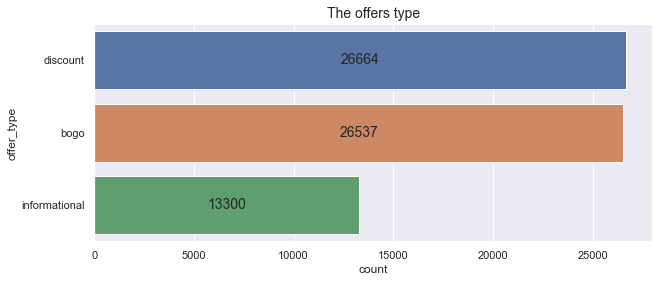

In [69]:
countplot_h(data = df_final["offer_type"], title = "The offers type")

As we can see on the graph, BOGO and Discount were sent to customers almost equally. In that time, Information type was sent two times less often. For avoiding imbalanced ML models, I will use only BOGO and Discount types as features.

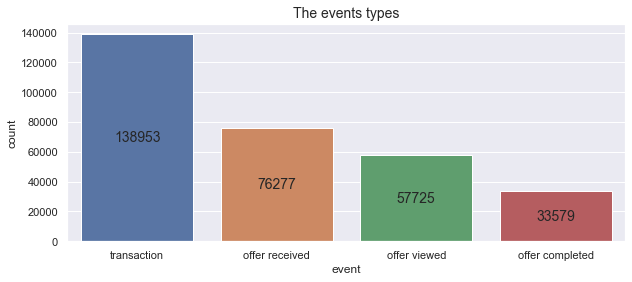

In [70]:
# Showing the ratio of transcripts by event
countplot_v(data = transcript["event"], title = "The events types")

In [71]:
received = (transcript["event"]=="offer received").sum()
viewed = (transcript["event"]=="offer viewed").sum() 
print (f"Open rate: {round((viewed /received) * 100)}%")

Open rate: 76%


#### According to Mailchimp average, the open rate in the Food Services Industry is 23.33%.
So open rate is 75.7% it is a fantastic result. I understand our data is mimic, but it is an excellent promotion if actual data is close to that result!

References: https://mailchimp.com/resources/email-marketing-benchmarks/

### What kind of offer was more successful?

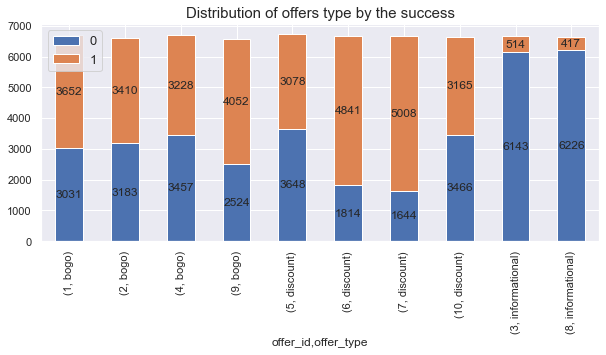

In [72]:
# Groupby "offer_id","offer_type", "offer successful" for plotting
offers_type_by_success = df_final.groupby(["offer_id",
                                           "offer_type", 
                                           "offer_successful"]).size()

offers_type_by_success = offers_type_by_success.unstack().sort_values(by= "offer_type")


# Using "bar_stacked " function
bar_stacked (offers_type_by_success, "Distribution of offers type by the success" )

In [73]:
# Creating DataFrame to find out the percent of success for each offer.
# Group by offer_id, offer_type, and offer_successfull for a total number of offers
total_offers = df_final.groupby(["offer_id", "offer_type"])["offer_successful"].size()


total_offers = pd.DataFrame(total_offers).reset_index()
# Rename offer_successful column into offers_total
total_offers.rename(columns = {"offer_successful": "offers_total"}, inplace = True)

# Group by offer_id, offer_type, and offer_successfull just for successful offers
success_offers = df_final.groupby(["offer_id", "offer_type"])["offer_successful"].sum()
success_offers = pd.DataFrame(success_offers).reset_index()

# Merge total_offers and success_offers
total_success_offers = total_offers.merge(success_offers, on = ["offer_id","offer_type"])

# Calculate percentage of success
total_success_offers["percent_success"] = round((total_success_offers["offer_successful"]
                                           / total_success_offers["offers_total"])*100, 2)

total_success_offers = total_success_offers.set_index('offer_id')

total_success_offers = total_success_offers.sort_values(by = "percent_success", ascending= False)

In [74]:
total_success_offers

,offer_type,offers_total,offer_successful,percent_success
offer_id,,,,
7,discount,6652,5008,75.29
6,discount,6655,4841,72.74
9,bogo,6576,4052,61.62
1,bogo,6683,3652,54.65
2,bogo,6593,3410,51.72
4,bogo,6685,3228,48.29
10,discount,6631,3165,47.73
5,discount,6726,3078,45.76
3,informational,6657,514,7.72


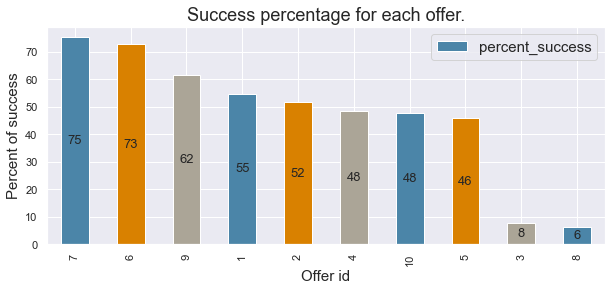

In [75]:
plot_bar(total_success_offers["percent_success"], 
         "Offer id", "Percent of success",
         "Success percentage for each offer.")

#### The most successful offers are 6 and 7. Both of them are discount-type. And successful rate equals 75% and 73%. The most unsuccessful are 3 and 8; both of them are informational. 

#### We can't analyze the best offer without finding how profitable it is. Now we see the offers which convert the most amount of money. 

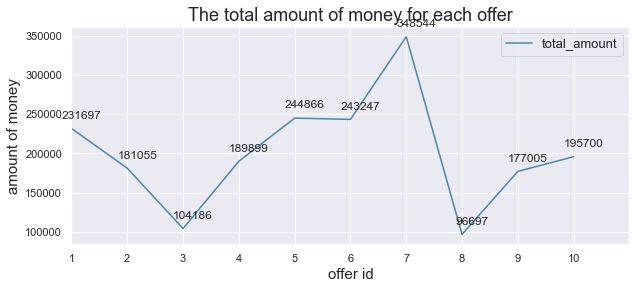

In [76]:
# Groupby "offer_id","offer_type", "offer successful" for plotting
offer_id_by_amount = pd.DataFrame(df_final.groupby(["offer_id"])["total_amount"].sum())

plot_line(offer_id_by_amount,"offer id", "amount of money", "The total amount of money for each offer")

#### The most successful offer is offer number 7, promoted discount of 2 dollars if the customer spends 10 dollars. The offer was valid for ten days and sent through all channels. The second successful offer is number 6. Also gave a discount, but 3 dollars if the customer spent 7 dollars. The offer was valid for seven days and was sent through all channels as well. Customers spent less than on offer 7 on 105 297 dollars. 

### Analysis of the demographics of customers who involved in the promotion

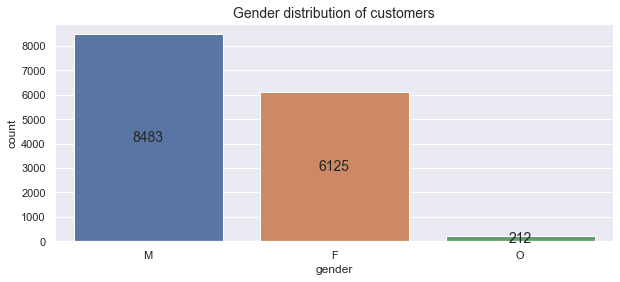

In [77]:
# Create a count plot with gender on the x-axis
gender = df_final.groupby(["customer_id","gender"]).count()
gender = gender.reset_index()

countplot_v(gender.gender, "Gender distribution of customers")


In [78]:
# Count the proportion of each gender
gender_prop = gender['gender'].value_counts()
m = int((gender_prop[0] / gender_prop.sum())*100) 
f = int((gender_prop[1] / gender_prop.sum())*100)
o = int((gender_prop[2] / gender_prop.sum())*100)

In [79]:
print (f"The customer base is divided into three genders: male (M), female (F),others(O).\n"
       f"All customers who indicate their gender: {gender_prop.sum()}.\n"
       f"The proportion of male (M) is {m} % ,the proportion of female (F) is {f} % and others equals {o} %")

The customer base is divided into three genders: male (M), female (F),others(O).
All customers who indicate their gender: 14820.
The proportion of male (M) is 57 % ,the proportion of female (F) is 41 % and others equals 1 %


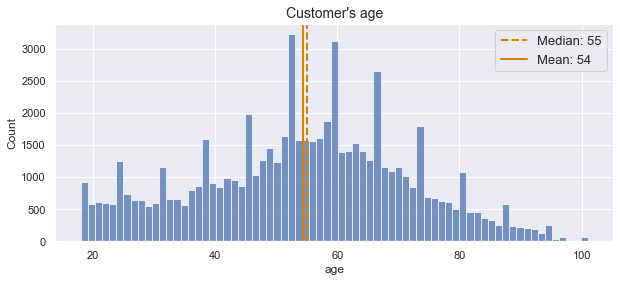

In [80]:
# Histogram of age
plotting_histplot(df_final["age"], "Customer's age" )

#### After dropping the missing value, the histogram shows a slight shift to the left in mean and median. The new average age for customers equals 54 years old, and the median is 55.

In [81]:
# Sorting data frame by age
df_final.sort_values("age", axis = 0, ascending = True,
                    inplace = True, na_position ='last')

In [82]:
# Filter age ranges, then replace age integer with strings
df_final.loc[df_final.age.between(18, 29), 'age_group'] = '18-29'
df_final.loc[df_final.age.between(30, 44), 'age_group'] = '30-44'
df_final.loc[df_final.age.between(45, 59), 'age_group'] = '45-59'
df_final.loc[df_final.age.between(60, 74), 'age_group'] = '60-74'
df_final.loc[df_final.age.between(75, 101), 'age_group'] = '75-101'


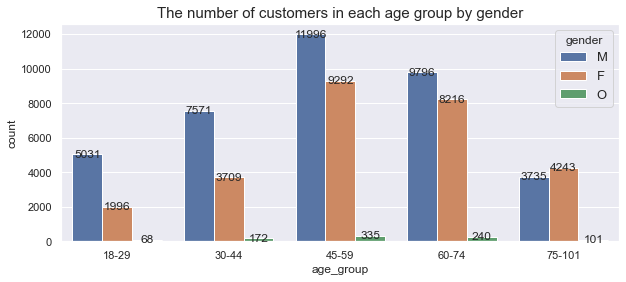

In [83]:
# Create a count plot of ages by gender
ax = sns.countplot( x = "age_group", data = df_final, hue = "gender")

# Set title
ax.set_title("The number of customers in each age group by gender", fontsize=15)

# Patches is everything inside of the chart
for rect in ax.patches:
    
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.0f}'

    # ax.text(x, y, text)
    label_x = x + width/2
    label_y = y + height

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(
        label_x,
        label_y,
        label_text,
        ha='center',
        va='center',
        fontsize=12
        )

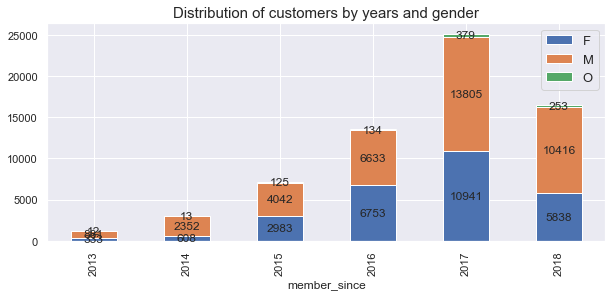

In [84]:
# Plot all gender average amount in years
profile_age_year = df_final.groupby(["member_since", "gender"]).size().unstack()


bar_stacked (profile_age_year, "Distribution of customers by years and gender")

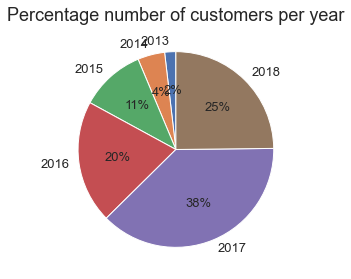

In [85]:
profile_year = df_final.groupby("member_since").size()
plot_pie(profile_year, profile_year.index, "Percentage number of customers per year")

The best year of attracted new customers was 2017. 38% of all the customers on the dataset enrolled this year. 13805 are male, and 10941 are female.

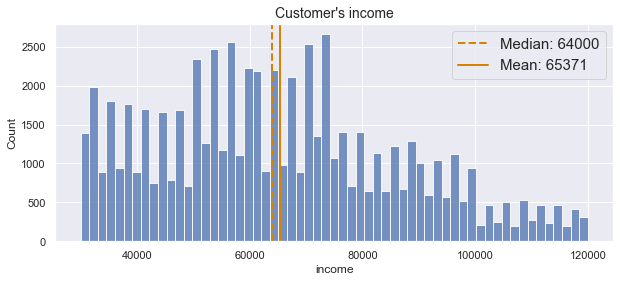

In [86]:
plotting_histplot(df_final["income"], "Customer's income" )

In [87]:
# Filter age ranges, then replace income integer with strings
df_final.loc[df_final.income.between(30000.0, 49999.0), 'income_group'] = '30k-50k'
df_final.loc[df_final.income.between(50000.0, 69999.0), 'income_group'] = '50k-70k'
df_final.loc[df_final.income.between(70000.0, 99999.0), 'income_group'] = '70k-90k'
df_final.loc[df_final.income.between(90000.0, 99999.0), 'income_group'] = '90k-100k'
df_final.loc[df_final.income.between(100000.0, 120000.0), 'income_group'] = '100k-120k'

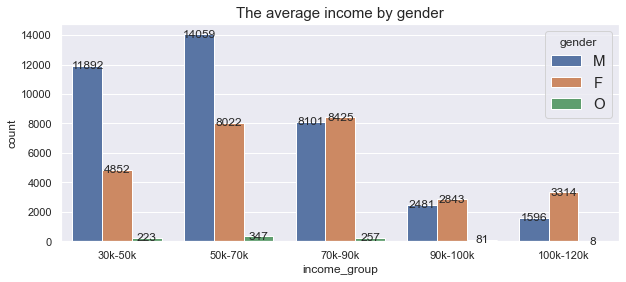

In [88]:
# Create a count plot of ages by gender
ax = sns.countplot( x = "income_group", data = df_final, hue = "gender")

# Set title
ax.set_title("The average income by gender", fontsize=15)

# Patches is everything inside of the chart
for rect in ax.patches:
    
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.0f}'

    # ax.text(x, y, text)
    label_x = x + width/2
    label_y = y + height

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(
        label_x,
        label_y,
        label_text,
        ha='center',
        va='center',
        fontsize=12
        )

We already know that the most successful offers are 7,6,5. 
Let's find who the customer who most loves those offers is.

In [89]:
most_success_offers = df_final.loc[df_final['offer_id'] == 7]

In [90]:
most_success_offers.head(2)

,customer_id,offer_id,time,offer_successful,total_amount,channels,difficulty,duration,offer_type,gender,age,member_since,income,age_group,income_group
39542,6bd1af2841a6412ebce35605cc4c394b,7,408,1,17,"[web, email, mobile, social]",10,240,discount,M,18,2015,60000,18-29,50k-70k
39599,8c93308bc4a243ba83f8294407894d69,7,0,0,0,"[web, email, mobile, social]",10,240,discount,M,18,2018,55000,18-29,50k-70k


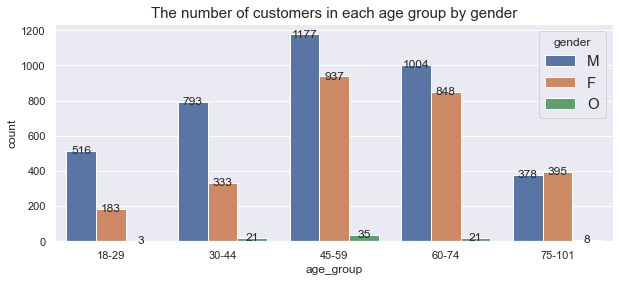

In [91]:
# Create a count plot of ages by gender
ax = sns.countplot( x = "age_group", data = most_success_offers, hue = "gender")

# Set title
ax.set_title("The number of customers in each age group by gender", fontsize=15)

# Patches is everything inside of the chart
for rect in ax.patches:
    
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.0f}'

    # ax.text(x, y, text)
    label_x = x + width/2
    label_y = y + height

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(
        label_x,
        label_y,
        label_text,
        ha='center',
        va='center',
        fontsize=12
        )

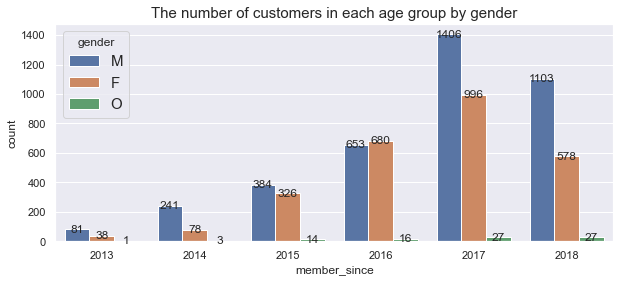

In [92]:
# Create a count plot of ages by gender
ax = sns.countplot( x = "member_since", data = most_success_offers, hue = "gender")

# Set title
ax.set_title("The number of customers in each age group by gender", fontsize=15)

# Patches is everything inside of the chart
for rect in ax.patches:
    
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.0f}'

    # ax.text(x, y, text)
    label_x = x + width/2
    label_y = y + height

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(
        label_x,
        label_y,
        label_text,
        ha='center',
        va='center',
        fontsize=12
        )

# Preprocessing

#### Missing value
One essential preprocessing step is dealing with a missing value because most machine learning algorithms can't handle any missing value and can cause errors.  We were already rid of all the missing values earlier, but it is always good to double-check it.

In [93]:
df_final.isna().sum()

customer_id         0
offer_id            0
time                0
offer_successful    0
total_amount        0
channels            0
difficulty          0
duration            0
offer_type          0
gender              0
age                 0
member_since        0
income              0
age_group           0
income_group        0
dtype: int64

#### Encoding categorical variables: one-hot.
Machine learning models in Python require numerical input. Several columns in our dataset are categorical. Because it contains variables with more than two categories, we need to apply one-hot encoding to transform those columns numerically. We will use Pandas' get_dummies() function.

get_dummies() is a quick and straightforward method to encode categorical variables.

In [94]:
#Convert the list of columns into dummy variables
list_col = ["offer_type", "gender", "age_group", "income_group","member_since"]

dummies = pd.get_dummies(df_final[list_col])

frames = [df_final,dummies]

df = pd.concat(frames, axis = 1)

df = df.drop(list_col, axis = 1)


In [95]:
# Convert the list of channels name into dummy variables 
channels_dummies  = df[['channels']].join(df.channels.str.join('|').str.get_dummies())
channels_dummies = channels_dummies.drop(["channels"], axis =1 )

df = pd.concat([df,channels_dummies], axis = 1)
df = df.drop("channels", axis =1)


In [96]:
# Remove "gender_","age_group_", "income_group_" from column name
df.columns = [col.replace("gender_", '') for col in df.columns]
df.columns  = [col.replace("age_group_", '') for col in df.columns]
df.columns  = [col.replace("income_group_", '') for col in df.columns]
df.columns  = [col.replace("offer_type_", '') for col in df.columns]

In [97]:
df = df.drop(['age', 'income'], axis=1)

In [98]:
df.head()

,customer_id,offer_id,time,offer_successful,total_amount,difficulty,duration,bogo,discount,informational,...,75-101,100k-120k,30k-50k,50k-70k,70k-90k,90k-100k,email,mobile,social,web
27219,5cb68688b66b42db8d1985340c289eb7,2,0,0,5,10,120,1,0,0,...,0,0,1,0,0,0,1,1,1,1
39541,6bd1af2841a6412ebce35605cc4c394b,1,336,0,7,10,168,1,0,0,...,0,0,0,1,0,0,1,1,1,0
39542,6bd1af2841a6412ebce35605cc4c394b,7,408,1,17,10,240,0,1,0,...,0,0,0,1,0,0,1,1,1,1
17690,2ba1d65405594702af723081531011ef,1,504,1,96,10,168,1,0,0,...,0,0,1,0,0,0,1,1,1,0
17689,2ba1d65405594702af723081531011ef,5,408,1,94,20,240,0,1,0,...,0,0,1,0,0,0,1,0,0,1


#### Feature selection

The main idea of feature selection is to exclude unnecessary features from the dataset.

Typically, unnecessary features are redundant. We don't include "received", "viewed", "completed," and "transaction" features in the modeling process because we already have accumulated values in the "offer_successful" column.  If we include those columns, we will end up duplicating the "offer_successful"  values, and it will be redundant.

Another technique we will use to detect what features to drop is a statistical correlation. When features are correlated,  they move together in one direction, which could introduce bias into the model. 

#### Correlations between the numerical variables
Usually, we want to avoid using variables with strong correlations with each other. It helps to keep the model simple and reduce the risk of overfitting.

#### To find out do we have any strongly correlated features, we will use the built-in _corr()_ function.

In [99]:
# Create a correlation matrix
var = df_final.drop(["offer_id","channels"], axis = 1 )
corr_metrics = var.corr()
corr_metrics.style.background_gradient()


,time,offer_successful,total_amount,difficulty,duration,age,member_since,income
time,1.000000,0.046944,0.019434,-0.003959,-0.003874,0.001255,-0.000635,-0.000615
offer_successful,0.046944,1.000000,0.374802,0.229377,0.294742,0.066232,-0.157677,0.143236
total_amount,0.019434,0.374802,1.000000,0.116274,0.160200,0.060383,-0.107331,0.181911
difficulty,-0.003959,0.229377,0.116274,1.000000,0.809257,-0.004088,-0.000513,-0.000858
duration,-0.003874,0.294742,0.160200,0.809257,1.000000,-0.003150,-0.000641,-0.002406
age,0.001255,0.066232,0.060383,-0.004088,-0.003150,1.000000,-0.010001,0.305156
member_since,-0.000635,-0.157677,-0.107331,-0.000513,-0.000641,-0.010001,1.000000,-0.026660
income,-0.000615,0.143236,0.181911,-0.000858,-0.002406,0.305156,-0.026660,1.000000


#### We can see that "duration" and "difficulty"  have a pretty strong correlation of 0.80, which means we won't use that features in the modeling.

In [100]:
# Define our features 
X = df.drop(["offer_successful","customer_id", "offer_id",
             "duration","difficulty","email", "social",
             "informational","O","100k-120k","70k-90k", 
             "90k-100k"], axis = 1)

# Define our labels
y = df["offer_successful"]


##  Building models

#### Finding the best model
I have prepared a Pipeline for each model it helps to find the best model. To evaluate models, I used the following metrics:  accuracy, precision, recall, f1-score. We are going to test fit four different models on the dataset. The  preferred models: 
- Logistic Regression
- K-Nearest Neighbors
- Decision Tree Classifier
- Random Forest: ensemble bagging classifier

In [101]:
X.shape

(66501, 15)

In [102]:
X.head()

,time,total_amount,bogo,discount,F,M,18-29,30-44,45-59,60-74,75-101,30k-50k,50k-70k,mobile,web
27219,0,5,1,0,0,1,1,0,0,0,0,1,0,1,1
39541,336,7,1,0,0,1,1,0,0,0,0,0,1,1,0
39542,408,17,0,1,0,1,1,0,0,0,0,0,1,1,1
17690,504,96,1,0,0,1,1,0,0,0,0,1,0,1,0
17689,408,94,0,1,0,1,1,0,0,0,0,1,0,0,1


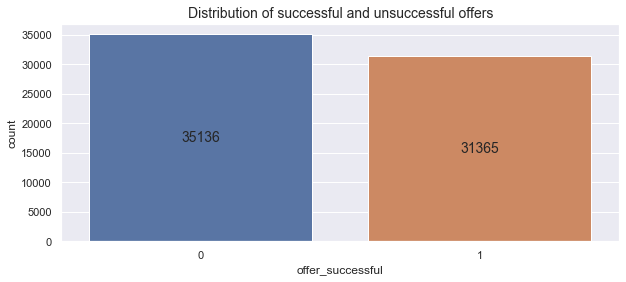

In [103]:
countplot_v(df_final["offer_successful"], "Distribution of successful and unsuccessful offers")

#### The data is slightly biased towards more number of unsuccessful offers (0). Because of that,  we use "stratify" when splitting the data into train and test sets.

Stratified is a good technique for sampling more accurately when the data is imbalanced, considering the distribution of features in the dataset.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Several features have numeric data and input values with differing scales; we have to scale those columns. In this case (project), I use the Data Standardization method. 

Standardizing involves rescaling the distribution of values in the way the mean of values is 0, and the standard deviation is 1. 

Standardization finds the mean of the data and centers distribution around it, calculating the number of standard deviations away from the mean each point is. These values are considered as new values. And this centers the data around 0 but technically has no limit to the maximum and minimum values.

But we have to be careful if we standardize the whole training dataset and then use cross-validation in grid search to evaluate the model; we've got data leakage. Data leakage is dangerous because the algorithm is already familiar with them; thus, it will worsen with new data. 

The solution here is to ensure that the standard scaler runs only on the training set and not the validation set within each fold of cross-validation. 


#### Pipelines allow us to do just this. 
In that case, standardization doesn't happen until we run a grid search
because the rescaling is included in the pipeline.

Preventing data leakage into the validation set helps that the rescaling is done only on the trained data for each fold of cross-validation.

Overfitting the dataset is a general problem in ML. When a model has learned the data too closely, it has the best achievements on the trained dataset but fails with new data. Too many features are one of the problems of overfitting. 

Cross-validation is a vital step in evaluating a model. It maximizes the amount of data used to train the model, as, during training, the model is trained and tested on all of the available data.

Cross-validation is essential but do not forget that the more folds you use, the more computationally expensive it becomes; thus, we will only 5.

References: https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

#### I built a Pipeline for each ML classifier, evaluated metrics, and compared them to each other.

### LogisticRegression

Logistic regression uses as the logistic function to compute the odds that a given data point relates to a given class.

In [118]:
# Setup the pipeline
steps_logreg = [("scaler", StandardScaler()),
               ("logreg", LogisticRegression())]

pipeline_logreg = Pipeline(steps_logreg)

# Specify the hyperparameter space
parameters_logreg = {"logreg__n_jobs": [-1, None]}

# Instantiate the GridSearchCV object: cv
cv_logreg = GridSearchCV(pipeline_logreg, parameters_logreg, cv = 5)

# Fit to the training set
cv_logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred_logreg = cv_logreg.predict(X_test)


# Print metrics for Logistic Regression
print(f"Logistic Regression model")
print("-------------------")
print(f"Classification report: \n {classification_report(y_test,y_pred_logreg)}")
print("-------------------")
print(f"Confusion matrix:\n {confusion_matrix(y_test, y_pred_logreg)}")
print("-------------------")
print(f"Accuracy score:\n {accuracy_score(y_test, y_pred_logreg)}")
print(f"Tuned Model Parameters: {cv_logreg.best_params_}")

Logistic Regression model
-------------------
Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.92      0.89      7028
           1       0.90      0.82      0.86      6273

    accuracy                           0.87     13301
   macro avg       0.88      0.87      0.87     13301
weighted avg       0.88      0.87      0.87     13301

-------------------
Confusion matrix:
 [[6466  562]
 [1112 5161]]
-------------------
Accuracy score:
 0.8741448011427713
Tuned Model Parameters: {'logreg__n_jobs': -1}


Tuned Model Parameters: {'logreg__n_jobs': -1}. -1 means using all processors.
By the default it is None, but we can see -1 works better.

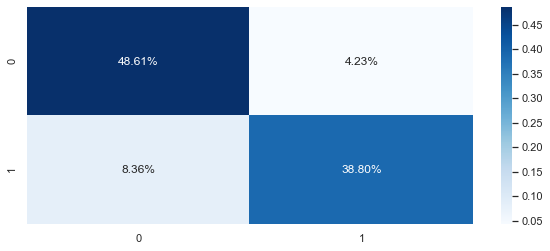

In [106]:
# Plot the confusion matrix
con_mat_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(con_mat_logreg /np.sum(con_mat_logreg ), annot=True, 
            fmt='.2%', cmap='Blues');


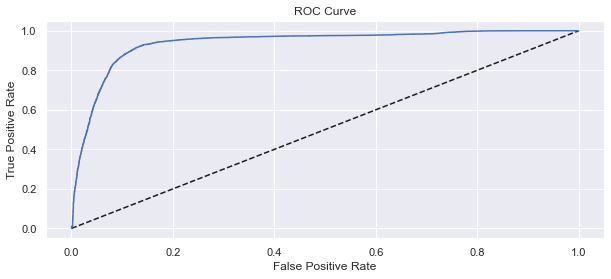

In [107]:
# Compute predicted probabilities: y_pred_prob_logreg
y_pred_prob_logreg = cv_logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr,tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Even though our logistic regression performance is good, we will not stop here. 

We can't immediately assume that it is the best model for our data, and we have to make sure we have done an excellent job.  Therefore, It's always a valuable idea to test a few other algorithms and find the best one for data.

### KNeighborsClassifier

K-Nearest Neighbors (KNN) is a classification algorithm. The basic idea is that data points with related attributes manage to fall into similar categories.

In [108]:
# Setup the pipeline
steps_knn = [("scaler", StandardScaler()),
             ("knn", KNeighborsClassifier())]

pipeline_knn = Pipeline(steps_knn)

# Specify the hyperparameter space
parameters_knn = { "knn__n_neighbors": [1,5],
                   "knn__weights" : ["uniform","distance"],
                   "knn__metric" : ["minkowski","euclidean","manhattan"]}

# Instantiate the GridSearchCV object: cv
cv_knn = GridSearchCV(pipeline_knn, parameters_knn, cv = 5)

# Fit to the training set
cv_knn.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred_knn = cv_knn.predict(X_test)

#probs_knn = knn.predict_proba(X_test)

# Print metrics for K-Neighbors Classifier
print(f"K-Neighbors Classifier model")
print("-------------------")
print(f"Classification report: \n {classification_report(y_test,y_pred_knn)}")
print("-------------------")
print(f"Confusion matrix:\n {confusion_matrix(y_test, y_pred_knn)}")
print("-------------------")
print(f"Accuracy score:\n {accuracy_score(y_test, y_pred_knn)}")
print(f"Tuned Model Parameters: {cv_knn.best_params_}")


K-Neighbors Classifier model
-------------------
Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7028
           1       0.87      0.90      0.88      6273

    accuracy                           0.89     13301
   macro avg       0.89      0.89      0.89     13301
weighted avg       0.89      0.89      0.89     13301

-------------------
Confusion matrix:
 [[6215  813]
 [ 654 5619]]
-------------------
Accuracy score:
 0.889707540786407
Tuned Model Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}


- Number of neighbors to use (n_neighbors): 5
- The distance metric to use for the tree: default metric is minkowski, but our model permor better with 'manhattan'. 
- ‘uniform’ : weights, means all points in each neighborhood are weighted equally

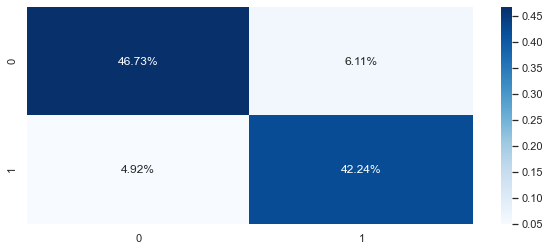

In [109]:
# Plot the confusion matrix
con_mat_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(con_mat_knn /np.sum(con_mat_knn), annot=True, 
            fmt='.2%', cmap='Blues');


#### Let's compute and plot the training and testing accuracy scores for different numbers of neighbors.

In [110]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 10)
train_acc = np.empty(len(neighbors))
test_acc = np.empty(len(neighbors))

# Loop over of k
for i, k in enumerate(neighbors):

    knn = KNeighborsClassifier(n_neighbors = k,  metric = "manhattan")
    knn.fit(X_train,y_train)
    
    train_acc[i] = knn.score(X_train, y_train)
    test_acc[i] = knn.score(X_test, y_test)
    

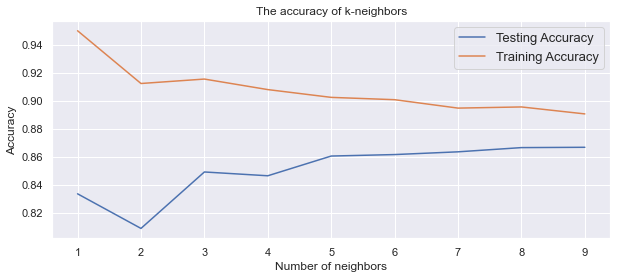

In [111]:
# Plotting testing and training accuracy
plt.title('The accuracy of k-neighbors')
plt.plot(neighbors, test_acc, label = 'Testing Accuracy')
plt.plot(neighbors, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()


After iterate through in the 1 to 10 range, the answer is the same. The best number of k_neighbor is 5. On that point, we have optimal test and train accuracy. 

## Decision Tree Classifier

Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to classify a data point. 

In [112]:
# Setup the pipeline
steps_tr = [("scaler", StandardScaler()),
            ("tr", DecisionTreeClassifier())]

pipeline_tr = Pipeline(steps_tr)

# Specify the hyperparameter space
parameters_tr = {"tr__criterion": ["gini",  "entropy"], 
                "tr__min_samples_split": [2, 10, 20], 
                "tr__max_depth": [None, 2, 5, 10]}

# Instantiate the GridSearchCV object: cv
cv_tr = GridSearchCV(pipeline_tr, parameters_tr, cv = 5)

# Fit to the training set
cv_tr.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred_tr = cv_tr.predict(X_test)

#probs_knn = knn.predict_proba(X_test)

# Print metrics for Decision Tree Classifier
print(f"Decision Tree Classifier")
print("-------------------")
print(f"Classification report: \n {classification_report(y_test,y_pred_tr)}")
print("-------------------")
print(f"Confusion matrix:\n {confusion_matrix(y_test, y_pred_tr)}")
print("-------------------")
print(f"Accuracy score:\n {accuracy_score(y_test, y_pred_tr)}")
print(f"Tuned Model Parameters: {cv_tr.best_params_}")


Decision Tree Classifier
-------------------
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.89      0.91      7028
           1       0.89      0.91      0.90      6273

    accuracy                           0.90     13301
   macro avg       0.90      0.90      0.90     13301
weighted avg       0.90      0.90      0.90     13301

-------------------
Confusion matrix:
 [[6288  740]
 [ 539 5734]]
-------------------
Accuracy score:
 0.9038418164047816
Tuned Model Parameters: {'tr__criterion': 'entropy', 'tr__max_depth': 10, 'tr__min_samples_split': 20}


- The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Model works better with not defaults "entropy" parameter.
- The minimum number of samples required to split an internal node: 20 
- The maximum depth of the tree: 10

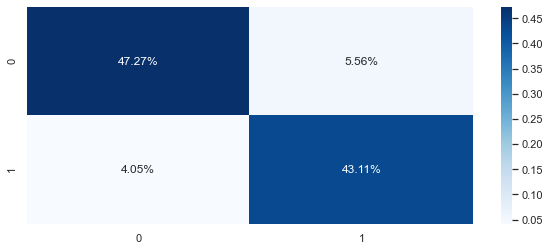

In [113]:
# Plot the confusion matrix
con_mat_tr = confusion_matrix(y_test, y_pred_tr)
sns.heatmap(con_mat_tr /np.sum(con_mat_tr), annot=True, 
            fmt='.2%', cmap='Blues');


## Random Forest Classifier

Random Forest limits overfitting by creating random subsets of the features and building smaller trees using these subsets. Then, it joins the subtrees of subsamples of features, so it does not overfit the entire feature set the way "deep" Decisions Trees do.

In [114]:
# Setup the pipeline
steps_rf = [("scaler", StandardScaler()),
            ("rf", RandomForestClassifier())]

pipeline_rf = Pipeline(steps_rf)

# Specify the hyperparameter space
parameters_rf = {"rf__n_estimators" : [1, 30],
                 "rf__max_features": ['auto', 'log2'], 
                 "rf__max_depth": [4, 8], 
                 "rf__criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object: cv
cv_rf = GridSearchCV(pipeline_rf, parameters_rf, cv = 5)

# Fit to the training set
cv_rf.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred_rf = cv_rf.predict(X_test)

#probs_knn = knn.predict_proba(X_test)

# Print metrics for Random Forest Classifier
print(f"Random Forest Classifier")
print("-------------------")
print(f"Classification report: \n {classification_report(y_test,y_pred_rf)}")
print("-------------------")
print(f"Confusion matrix:\n {confusion_matrix(y_test, y_pred_rf)}")
print("-------------------")
print(f"Accuracy score:\n {accuracy_score(y_test, y_pred_rf)}")
print(cross_val_score(cv_rf, X, y, cv = 5))
print(f"Tuned Model Parameters: {cv_rf.best_params_}")


Random Forest Classifier
-------------------
Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.88      0.91      7028
           1       0.88      0.93      0.90      6273

    accuracy                           0.90     13301
   macro avg       0.90      0.91      0.90     13301
weighted avg       0.91      0.90      0.90     13301

-------------------
Confusion matrix:
 [[6195  833]
 [ 438 5835]]
-------------------
Accuracy score:
 0.9044432749417337
[0.88910608 0.90210526 0.90172932 0.90541353 0.90052632]
Tuned Model Parameters: {'rf__criterion': 'gini', 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__n_estimators': 30}


- The number of trees in the forest: 30 (n_estimators)
- Unlike Decision Tree, the Random Forest model takes "criterion": "gini".
- The maximum depth of the tree: 8
- The number of features to consider when looking for the best split: 'auto'

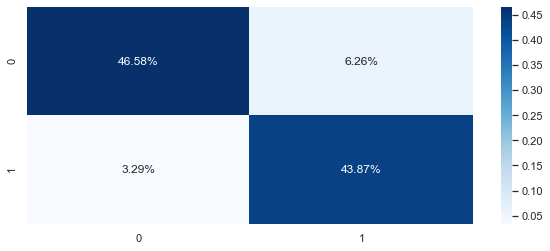

In [115]:
# Plot the confusion matrix
con_mat_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(con_mat_rf /np.sum(con_mat_rf), annot=True, 
            fmt='.2%', cmap='Blues');


Random Forest model shows the hights Recall score - 93%. Almost the same F1 score as the Decision tree model - 90% and pretty good accuracy score - 90%.

In [116]:
# Accumulate all metrics in one df
cls_metrics_dict = {"logreg": {"accuracy" :accuracy_score(y_test, y_pred_logreg),
                               "precision":precision_score(y_test, y_pred_logreg),
                               "recall" : recall_score(y_test, y_pred_logreg),
                                "f1" : f1_score(y_test, y_pred_logreg, average='macro')},
                    
                    "knn": {"accuracy" : accuracy_score(y_test, y_pred_knn),
                           "precision": precision_score(y_test, y_pred_knn),
                           "recall" : recall_score(y_test, y_pred_knn),
                           "f1" : f1_score(y_test, y_pred_knn, average='macro')},
                    
                    "cls_tree": {"accuracy" : accuracy_score(y_test, y_pred_tr),
                                "precision": precision_score(y_test, y_pred_tr),
                                "recall" : recall_score(y_test, y_pred_tr),
                                "f1" : f1_score(y_test, y_pred_tr, average='macro')},
                    
                     "random_forest" : {"accuracy" : accuracy_score(y_test, y_pred_rf),
                                      "precision": precision_score(y_test, y_pred_rf),
                                      "recall" : recall_score(y_test, y_pred_rf),
                                       "f1" : f1_score(y_test, y_pred_rf, average='macro')}}


In [117]:
cls_metrics = pd.DataFrame(cls_metrics_dict)
cls_metrics

,logreg,knn,cls_tree,random_forest
accuracy,0.874145,0.889708,0.903842,0.904443
precision,0.901800,0.873601,0.885697,0.875075
recall,0.822732,0.895744,0.914076,0.930177
f1,0.872922,0.889486,0.903675,0.904373


#### Conclusion

In the end, we know that the best offer is offer number 7: promoted discount of 2 dollars if the customer spends 10 dollars. The offer was valid for ten days and sent through all channels. And the average person who is most influenced by that offer: male, 40-60 years old, with 50 - 70k income, and he has been a member since the 2017 year.

#### Summary

- Cleaning the df to make sure it is no noise in the data.
- Combine all tree data sets into one. It was the tricky part; thanks to the Udacity mentors for helping here.
- Implemented EDAs on the datasets to determine how the different demographics of customers reacted to the various offer types. Finding the best offer in the data set.
- Preprocessed the data to ensure it was ready for the predictive algorithms.
- I used several models to predict which proposal would be successful.

References:

[https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173](https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173)

[https://www.geeksforgeeks.org/python-program-to-swap-keys-and-values-in-dictionary/](https://www.geeksforgeeks.org/python-program-to-swap-keys-and-values-in-dictionary/)

[https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

[https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

[https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/)

https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

[https://towardsdatascience.com/normalization-vs-standardization-explained-209e84d0f81e](https://towardsdatascience.com/normalization-vs-standardization-explained-209e84d0f81e)

[https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9](https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9)

[https://github.com/Surveshchauhan/StarbucksKNowledge](https://github.com/Surveshchauhan/StarbucksKNowledge)

[https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)

[https://pandas.pydata.org/docs/reference/api/pandas.concat.html](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)

[https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)

[https://scikit-learn.org/stable/modules/tree.html](https://scikit-learn.org/stable/modules/tree.html)